<a href="https://colab.research.google.com/github/rajesh-coventry/Foundational-Neural-Network-Perceptron-PyTorch/blob/master/05_How_to_Create_Neural_Network_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Create Neural Network in PyTorch:**

### 1. **Data Preparation:**
- Custom Dataset class for PyTorch

- Data preprocessing (scaling, encoding)

- Automatic train/validation/test splitting

- DataLoader creation with proper batching

### 2. **Model Building:**
- Flexible neural network architecture (`FlexibleNN`)

- Configurable hidden layers, dropout, batch normalization

- Support for both classification and regression

- Proper weight initialization

### 3. **Model Training:**
- Complete training loop with progress bars

- Early stopping to prevent overfitting

- Learning rate scheduling

- Support for both CPU and GPU training

- Comprehensive training history tracking

### 4. **Prediction & Testing:**
- Prediction functions for new data

- Comprehensive model evaluation

- Support for both classification and regression metrics

### 5. **Performance Testing:**
- Classification metrics: accuracy, precision, recall, F1-score, confusion matrix

- Regression metrics: MSE, RMSE, MAE, R²-score

- Overfitting detection and analysis

### 6. **Visualization:**
The framework provides extensive visualizations to assess model performance:

**Training Visualizations:**
- **`Loss curves`**: Track training and validation loss to detect overfitting

- **`Accuracy curves`**: Monitor training and validation accuracy over time

- **`Learning rate schedule`**: See how learning rate changes during training

- **`Overfitting indicator`**: Plot showing validation loss - training loss difference

**Classification Visualizations:**
- **`Confusion matrix`**: See which classes are being confused

- **`Prediction distribution`**: Check if predictions are balanced

- **`Confidence distribution`**: Analyze model confidence in predictions

- **`Per-class accuracy`**: Identify which classes perform poorly

**Regression Visualizations:**
- **`Actual vs Predicted scatter plot`**: Check prediction quality

- **`Residual plot`**: Detect patterns in errors

- **`Residuals distribution`**: Check if errors are normally distributed

- **`Error metrics bar chart`**: Compare different error metrics

## **Key Features:**

1. **`Easy to Use`**: Single function `complete_training_workflow()` handles everything

2. **`Flexible`**: Configurable model architecture and training parameters

3. **`Robust`**: Includes early stopping, learning rate scheduling, and proper validation

4. **`Comprehensive`**: Full evaluation with multiple metrics and visualizations

5. **`Saveable`**: Automatically saves models, configs, and results

6. **`Reusable`**: Load saved models and make predictions on new data

## **What to Look for in Visualizations:**

**Good Model Indicators:**
- Loss curves converging without large gaps

- Validation accuracy close to training accuracy

- Residuals randomly distributed around zero
(regression)

- High confidence in correct predictions (classification)

- Confusion matrix with strong diagonal values

**Warning Signs:**
- Large gap between training and validation loss (overfitting)

- Validation metrics plateauing early (underfitting)

- Systematic patterns in residual plots (regression)

- Low confidence in predictions

- Poor per-class performance for specific classes

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from tqdm import tqdm
import os
import json
from typing import Tuple, Dict, List, Optional

## **1. DATA PREPARATION:**

In [2]:
# DATA PREPARATION

class CustomDataset(Dataset):
    """
    Custom Dataset class for PyTorch
    Modify this based on your specific data format
    """
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y) if y.dtype != np.float32 else torch.FloatTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        target = self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, target

def prepare_data(X, y, test_size=0.2, val_size=0.1, batch_size=32, random_seed=42):
    """
    Prepare data for training, validation, and testing

    Args:
        X: Input features
        y: Target labels
        test_size: Proportion of data for testing
        val_size: Proportion of training data for validation
        batch_size: Batch size for DataLoader
        random_seed: Random seed for reproducibility

    Returns:
        train_loader, val_loader, test_loader, input_size, num_classes
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Create dataset
    dataset = CustomDataset(X, y)

    # Calculate split sizes
    total_size = len(dataset)
    test_size_abs = int(test_size * total_size)
    train_val_size = total_size - test_size_abs
    val_size_abs = int(val_size * train_val_size)
    train_size_abs = train_val_size - val_size_abs

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size_abs, val_size_abs, test_size_abs],
        generator=torch.Generator().manual_seed(random_seed)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get input size and number of classes
    input_size = X.shape[1] if len(X.shape) == 2 else X.shape[1:]
    num_classes = len(np.unique(y))

    print(f"Data split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    print(f"Input size: {input_size}, Number of classes: {num_classes}")

    return train_loader, val_loader, test_loader, input_size, num_classes

def preprocess_data(X, y, scale_features=True):
    """
    Preprocess the data (scaling, encoding, etc.)

    Args:
        X: Input features
        y: Target labels
        scale_features: Whether to scale features

    Returns:
        Preprocessed X and y
    """
    # Feature scaling
    if scale_features:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Label encoding (if needed)
    if y.dtype == 'object':
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

    return X.astype(np.float32), y.astype(np.int64)


## **2. MODEL BUILDING:**

In [3]:
# MODEL BUILDING

class FlexibleNN(nn.Module):
    """
    Flexible Neural Network architecture that can be configured for different tasks
    """
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.2,
                 activation='relu', batch_norm=True, task_type='classification'):
        super(FlexibleNN, self).__init__()

        self.task_type = task_type

        # Define activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.ReLU()

        # Build layers
        layers = []
        prev_size = input_size if isinstance(input_size, int) else np.prod(input_size)

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(self.activation)
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        if task_type == 'classification':
            layers.append(nn.Linear(prev_size, num_classes))
        elif task_type == 'regression':
            layers.append(nn.Linear(prev_size, 1 if num_classes == 1 else num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Flatten input if needed
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        return self.network(x)

def create_model(input_size, num_classes, hidden_sizes=[128, 64],
                dropout_rate=0.2, activation='relu', batch_norm=True,
                task_type='classification'):
    """
    Factory function to create a neural network model

    Args:
        input_size: Size of input features
        num_classes: Number of output classes/targets
        hidden_sizes: List of hidden layer sizes
        dropout_rate: Dropout probability
        activation: Activation function type
        batch_norm: Whether to use batch normalization
        task_type: 'classification' or 'regression'

    Returns:
        PyTorch model
    """
    model = FlexibleNN(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation=activation,
        batch_norm=batch_norm,
        task_type=task_type
    )

    return model


## **3. MODEL TRAINING:**

In [4]:
# MODEL TRAINING

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001,
                task_type='classification', patience=10, device='auto'):
    """
    Train the neural network model

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        task_type: 'classification' or 'regression'
        patience: Early stopping patience
        device: Device to train on ('auto', 'cpu', 'cuda')

    Returns:
        model, training_history
    """

    # Set device
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    model = model.to(device)
    print(f"Training on device: {device}")

    # Define loss function and optimizer
    if task_type == 'classification':
        criterion = nn.CrossEntropyLoss()
    else:  # regression
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'learning_rates': []
    }

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            if task_type == 'classification':
                loss = criterion(output, target)
                _, predicted = torch.max(output.data, 1)
                train_correct += (predicted == target).sum().item()
            else:  # regression
                if target.dim() == 1:
                    target = target.unsqueeze(1)
                loss = criterion(output, target.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_total += target.size(0)

            # Update progress bar
            if task_type == 'classification':
                train_acc = 100. * train_correct / train_total
                train_pbar.set_postfix({'Loss': f'{train_loss/(batch_idx+1):.4f}', 'Acc': f'{train_acc:.2f}%'})
            else:
                train_pbar.set_postfix({'Loss': f'{train_loss/(batch_idx+1):.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)

                if task_type == 'classification':
                    val_loss += criterion(output, target).item()
                    _, predicted = torch.max(output.data, 1)
                    val_correct += (predicted == target).sum().item()
                else:  # regression
                    if target.dim() == 1:
                        target = target.unsqueeze(1)
                    val_loss += criterion(output, target.float()).item()

                val_total += target.size(0)

        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        if task_type == 'classification':
            train_accuracy = 100. * train_correct / train_total
            val_accuracy = 100. * val_correct / val_total
            history['train_acc'].append(train_accuracy)
            history['val_acc'].append(val_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        else:
            print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Early stopping
        if early_stopping(avg_val_loss, model):
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    return model, history


## **4. PREDICTION:**

In [5]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, mean_squared_error, mean_absolute_error, r2_score
)

def make_predictions(model, data_loader, device='auto', task_type='classification'):
    """
    Make predictions using the trained model (FIXED VERSION)

    Args:
        model: Trained PyTorch model
        data_loader: Data loader for predictions
        device: Device to use
        task_type: 'classification' or 'regression'

    Returns:
        predictions, true_labels, probabilities (for classification)
    """
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    print(f"Making predictions on {len(data_loader)} batches...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Debug print for first few batches
            if batch_idx < 3:
                print(f"Batch {batch_idx}: data shape {data.shape}, target shape {target.shape}, output shape {output.shape}")

            if task_type == 'classification':
                # Get probabilities and predictions
                probs = torch.softmax(output, dim=1)
                _, predicted = torch.max(output, 1)

                # Convert to numpy and extend lists
                probabilities.extend(probs.cpu().numpy())
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(target.cpu().numpy())
            else:  # regression
                # For regression, ensure output is flattened properly
                pred_batch = output.cpu().numpy()
                target_batch = target.cpu().numpy()

                # Handle different output shapes
                if pred_batch.ndim > 1:
                    pred_batch = pred_batch.flatten()
                if target_batch.ndim > 1:
                    target_batch = target_batch.flatten()

                predictions.extend(pred_batch)
                true_labels.extend(target_batch)

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    print(f"Final predictions shape: {predictions.shape}")
    print(f"Final true_labels shape: {true_labels.shape}")

    # Verify shapes match
    if len(predictions) != len(true_labels):
        print(f"WARNING: Shape mismatch! Predictions: {len(predictions)}, Labels: {len(true_labels)}")
        # Truncate to smaller size to avoid error
        min_size = min(len(predictions), len(true_labels))
        predictions = predictions[:min_size]
        true_labels = true_labels[:min_size]
        print(f"Truncated to size: {min_size}")

    if task_type == 'classification':
        probabilities = np.array(probabilities)
        return predictions, true_labels, probabilities
    else:
        return predictions, true_labels, None


## **5. TESTING LOOP:**

In [6]:

def evaluate_model(model, test_loader, device='auto', task_type='classification'):
    """
    Evaluate model performance on test set (FIXED VERSION)

    Args:
        model: Trained model
        test_loader: Test data loader
        device: Device to use
        task_type: 'classification' or 'regression'

    Returns:
        evaluation_results dictionary
    """
    print(f"Evaluating model on test set with {len(test_loader)} batches...")

    predictions, true_labels, probabilities = make_predictions(
        model, test_loader, device, task_type
    )

    results = {}

    # Debug prints to check shapes
    print(f"Evaluation - Predictions shape: {predictions.shape}")
    print(f"Evaluation - True labels shape: {true_labels.shape}")

    # Additional shape verification
    if predictions.shape != true_labels.shape:
        print(f"ERROR: Shape mismatch in evaluation!")
        print(f"Predictions shape: {predictions.shape}")
        print(f"True labels shape: {true_labels.shape}")

        # Try to fix by ensuring both are 1D
        predictions = predictions.flatten()
        true_labels = true_labels.flatten()

        print(f"After flattening - Predictions: {predictions.shape}, Labels: {true_labels.shape}")

        # If still mismatched, truncate
        if len(predictions) != len(true_labels):
            min_size = min(len(predictions), len(true_labels))
            predictions = predictions[:min_size]
            true_labels = true_labels[:min_size]
            print(f"Truncated both to size: {min_size}")

    if task_type == 'classification':
        # Classification metrics
        results['accuracy'] = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted', zero_division=0
        )
        results['precision'] = precision
        results['recall'] = recall
        results['f1_score'] = f1
        results['confusion_matrix'] = confusion_matrix(true_labels, predictions)
        results['classification_report'] = classification_report(
            true_labels, predictions, zero_division=0
        )
        results['predictions'] = predictions
        results['true_labels'] = true_labels
        results['probabilities'] = probabilities

    else:  # regression
        # Regression metrics
        try:
            results['mse'] = mean_squared_error(true_labels, predictions)
            results['rmse'] = np.sqrt(results['mse'])
            results['mae'] = mean_absolute_error(true_labels, predictions)
            results['r2_score'] = r2_score(true_labels, predictions)
            results['predictions'] = predictions
            results['true_labels'] = true_labels

            print(f"Regression metrics calculated successfully:")
            print(f"MSE: {results['mse']:.4f}")
            print(f"RMSE: {results['rmse']:.4f}")
            print(f"MAE: {results['mae']:.4f}")
            print(f"R²: {results['r2_score']:.4f}")

        except Exception as e:
            print(f"Error calculating regression metrics: {e}")
            print(f"Predictions shape: {predictions.shape}, type: {type(predictions)}")
            print(f"True labels shape: {true_labels.shape}, type: {type(true_labels)}")
            raise

    return results



## **6. COMPREHENSIVE MODEL PERFORMANCE TESTING:**

In [7]:
# COMPREHENSIVE MODEL PERFORMANCE TESTING

def comprehensive_evaluation(model, test_loader, val_loader=None, device='auto',
                           task_type='classification', class_names=None):
    """
    Perform comprehensive model evaluation

    Args:
        model: Trained model
        test_loader: Test data loader
        val_loader: Validation data loader (optional)
        device: Device to use
        task_type: 'classification' or 'regression'
        class_names: List of class names for classification

    Returns:
        comprehensive_results dictionary
    """
    results = {}

    # Test set evaluation
    print("Evaluating on test set...")
    test_results = evaluate_model(model, test_loader, device, task_type)
    results['test'] = test_results

    # Validation set evaluation (if provided)
    if val_loader is not None:
        print("Evaluating on validation set...")
        val_results = evaluate_model(model, val_loader, device, task_type)
        results['validation'] = val_results

    # Print results
    if task_type == 'classification':
        print(f"\n=== CLASSIFICATION RESULTS ===")
        print(f"Test Accuracy: {test_results['accuracy']:.4f}")
        print(f"Test Precision: {test_results['precision']:.4f}")
        print(f"Test Recall: {test_results['recall']:.4f}")
        print(f"Test F1-Score: {test_results['f1_score']:.4f}")
        print(f"\nClassification Report:")
        print(test_results['classification_report'])

    else:  # regression
        print(f"\n=== REGRESSION RESULTS ===")
        print(f"Test MSE: {test_results['mse']:.4f}")
        print(f"Test RMSE: {test_results['rmse']:.4f}")
        print(f"Test MAE: {test_results['mae']:.4f}")
        print(f"Test R² Score: {test_results['r2_score']:.4f}")

    return results


## **7. VISUALIZATION:**

In [8]:
# VISUALIZATION

def visualize_training_history(history, save_path=None):
    """
    Visualize training history

    Args:
        history: Training history dictionary
        save_path: Path to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy curves (if available)
    if 'train_acc' in history and 'val_acc' in history:
        axes[0, 1].plot(history['train_acc'], label='Train Accuracy', color='blue')
        axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', color='red')
        axes[0, 1].set_title('Training and Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    else:
        axes[0, 1].text(0.5, 0.5, 'Accuracy not available\n(Regression task)',
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Accuracy (Not Available)')

    # Learning rate schedule
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)

    # Loss difference (overfitting indicator)
    loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(loss_diff, color='purple')
    axes[1, 1].set_title('Overfitting Indicator (Val Loss - Train Loss)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def visualize_classification_results(results, class_names=None, save_path=None):
    """
    Visualize classification results

    Args:
        results: Results from comprehensive_evaluation
        class_names: List of class names
        save_path: Path to save the plot
    """
    test_results = results['test']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix
    cm = test_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=class_names, yticklabels=class_names)
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')

    # Prediction Distribution
    axes[0, 1].hist(test_results['predictions'], bins=len(np.unique(test_results['predictions'])),
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Prediction Distribution')
    axes[0, 1].set_xlabel('Predicted Class')
    axes[0, 1].set_ylabel('Count')

    # Confidence Distribution (if probabilities available)
    if test_results['probabilities'] is not None:
        max_probs = np.max(test_results['probabilities'], axis=1)
        axes[1, 0].hist(max_probs, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Prediction Confidence Distribution')
        axes[1, 0].set_xlabel('Max Probability')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].axvline(x=np.mean(max_probs), color='red', linestyle='--',
                          label=f'Mean: {np.mean(max_probs):.3f}')
        axes[1, 0].legend()

    # Per-class accuracy
    per_class_acc = []
    unique_classes = np.unique(test_results['true_labels'])
    for cls in unique_classes:
        mask = test_results['true_labels'] == cls
        if np.sum(mask) > 0:
            acc = np.mean(test_results['predictions'][mask] == test_results['true_labels'][mask])
            per_class_acc.append(acc)
        else:
            per_class_acc.append(0)

    class_labels = class_names if class_names else [f'Class {i}' for i in unique_classes]
    axes[1, 1].bar(class_labels, per_class_acc, color='orange', alpha=0.7)
    axes[1, 1].set_title('Per-Class Accuracy')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def visualize_regression_results(results, save_path=None):
    """
    Visualize regression results

    Args:
        results: Results from comprehensive_evaluation
        save_path: Path to save the plot
    """
    test_results = results['test']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Actual vs Predicted
    axes[0, 0].scatter(test_results['true_labels'], test_results['predictions'],
                      alpha=0.6, color='blue')

    # Perfect prediction line
    min_val = min(test_results['true_labels'].min(), test_results['predictions'].min())
    max_val = max(test_results['true_labels'].max(), test_results['predictions'].max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    axes[0, 0].set_title(f'Actual vs Predicted (R² = {test_results["r2_score"]:.3f})')
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].grid(True, alpha=0.3)

    # Residuals
    residuals = test_results['true_labels'] - test_results['predictions']
    axes[0, 1].scatter(test_results['predictions'], residuals, alpha=0.6, color='green')
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].grid(True, alpha=0.3)

    # Residuals histogram
    axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_title('Residuals Distribution')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(x=0, color='red', linestyle='--')

    # Error metrics visualization
    metrics = ['MSE', 'RMSE', 'MAE']
    values = [test_results['mse'], test_results['rmse'], test_results['mae']]

    axes[1, 1].bar(metrics, values, color=['red', 'orange', 'yellow'], alpha=0.7)
    axes[1, 1].set_title('Error Metrics')
    axes[1, 1].set_ylabel('Error Value')

    # Add value labels on bars
    for i, v in enumerate(values):
        axes[1, 1].text(i, v + max(values) * 0.01, f'{v:.3f}',
                       ha='center', va='bottom')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def create_model_summary_report(model, results, history, save_path=None):
    """
    Create a comprehensive model summary report

    Args:
        model: Trained model
        results: Evaluation results
        history: Training history
        save_path: Path to save the report
    """
    report = []
    report.append("=" * 50)
    report.append("MODEL SUMMARY REPORT")
    report.append("=" * 50)

    # Model architecture
    report.append("\n1. MODEL ARCHITECTURE:")
    report.append("-" * 30)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    report.append(f"Total parameters: {total_params:,}")
    report.append(f"Trainable parameters: {trainable_params:,}")
    report.append(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

    # Training summary
    report.append("\n2. TRAINING SUMMARY:")
    report.append("-" * 30)
    report.append(f"Total epochs trained: {len(history['train_loss'])}")
    report.append(f"Final training loss: {history['train_loss'][-1]:.4f}")
    report.append(f"Final validation loss: {history['val_loss'][-1]:.4f}")
    report.append(f"Best validation loss: {min(history['val_loss']):.4f}")

    if 'train_acc' in history:
        report.append(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
        report.append(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
        report.append(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

    # Performance metrics
    report.append("\n3. PERFORMANCE METRICS:")
    report.append("-" * 30)

    test_results = results['test']
    if 'accuracy' in test_results:  # Classification
        report.append(f"Test Accuracy: {test_results['accuracy']:.4f}")
        report.append(f"Test Precision: {test_results['precision']:.4f}")
        report.append(f"Test Recall: {test_results['recall']:.4f}")
        report.append(f"Test F1-Score: {test_results['f1_score']:.4f}")
    else:  # Regression
        report.append(f"Test MSE: {test_results['mse']:.4f}")
        report.append(f"Test RMSE: {test_results['rmse']:.4f}")
        report.append(f"Test MAE: {test_results['mae']:.4f}")
        report.append(f"Test R² Score: {test_results['r2_score']:.4f}")

    # Overfitting analysis
    report.append("\n4. OVERFITTING ANALYSIS:")
    report.append("-" * 30)
    final_loss_diff = history['val_loss'][-1] - history['train_loss'][-1]
    report.append(f"Final loss difference (val - train): {final_loss_diff:.4f}")

    if final_loss_diff > 0.1:
        report.append("⚠️  WARNING: Model may be overfitting")
    elif final_loss_diff < -0.05:
        report.append("⚠️  WARNING: Model may be underfitting")
    else:
        report.append("✅ Model appears well-fitted")

    # Recommendations
    report.append("\n5. RECOMMENDATIONS:")
    report.append("-" * 30)

    if final_loss_diff > 0.1:
        report.append("• Consider increasing dropout rate")
        report.append("• Add more regularization")
        report.append("• Reduce model complexity")
        report.append("• Collect more training data")
    elif final_loss_diff < -0.05:
        report.append("• Consider increasing model complexity")
        report.append("• Reduce regularization")
        report.append("• Train for more epochs")
        report.append("• Check for data quality issues")
    else:
        report.append("• Model performance looks good")
        report.append("• Consider ensemble methods for further improvement")

    report_text = "\n".join(report)
    print(report_text)

    if save_path:
        with open(save_path, 'w') as f:
            f.write(report_text)

    return report_text


In [16]:
# 7. VISUALIZATION

def visualize_training_history(history, save_path=None):
    """
    Visualize training history

    Args:
        history: Training history dictionary
        save_path: Path to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy curves (if available)
    if 'train_acc' in history and 'val_acc' in history and history['train_acc'] and history['val_acc']:
        axes[0, 1].plot(history['train_acc'], label='Train Accuracy', color='blue')
        axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', color='red')
        axes[0, 1].set_title('Training and Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    else:
        axes[0, 1].text(0.5, 0.5, 'Accuracy not available\n(Regression task or no data)',
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Accuracy (Not Available)')

    # Learning rate schedule
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)

    # Loss difference (overfitting indicator)
    if history['val_loss'] and history['train_loss']: # Ensure lists are not empty
        loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
        axes[1, 1].plot(loss_diff, color='purple')
        axes[1, 1].set_title('Overfitting Indicator (Val Loss - Train Loss)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss Difference')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].grid(True)
    else:
         axes[1, 1].text(0.5, 0.5, 'Loss difference not available',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
         axes[1, 1].set_title('Overfitting Indicator (Not Available)')


    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def visualize_classification_results(results, class_names=None, save_path=None):
    """
    Visualize classification results

    Args:
        results: Results from comprehensive_evaluation
        class_names: List of class names
        save_path: Path to save the plot
    """
    test_results = results['test']

    # Ensure predictions and true_labels are in results before plotting
    if 'predictions' not in test_results or 'true_labels' not in test_results:
         print("Classification visualizations skipped: 'predictions' or 'true_labels' not found in results.")
         return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix
    if 'confusion_matrix' in test_results:
        cm = test_results['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                    xticklabels=class_names, yticklabels=class_names)
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')
    else:
         axes[0, 0].text(0.5, 0.5, 'Confusion Matrix not available',
                       ha='center', va='center', transform=axes[0, 0].transAxes)
         axes[0, 0].set_title('Confusion Matrix (Not Available)')


    # Prediction Distribution
    if len(test_results['predictions']) > 0:
        axes[0, 1].hist(test_results['predictions'], bins=len(np.unique(test_results['predictions'])),
                       alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 1].set_title('Prediction Distribution')
        axes[0, 1].set_xlabel('Predicted Class')
        axes[0, 1].set_ylabel('Count')
    else:
        axes[0, 1].text(0.5, 0.5, 'Prediction Distribution not available\n(No predictions)',
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Prediction Distribution (Not Available)')


    # Confidence Distribution (if probabilities available)
    if test_results.get('probabilities') is not None and len(test_results['probabilities']) > 0:
        max_probs = np.max(test_results['probabilities'], axis=1)
        axes[1, 0].hist(max_probs, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Prediction Confidence Distribution')
        axes[1, 0].set_xlabel('Max Probability')
        axes[1, 0].set_ylabel('Count')
        if len(max_probs) > 0: # Prevent calculating mean of empty array
             axes[1, 0].axvline(x=np.mean(max_probs), color='red', linestyle='--',
                              label=f'Mean: {np.mean(max_probs):.3f}')
             axes[1, 0].legend()
    else:
         axes[1, 0].text(0.5, 0.5, 'Confidence Distribution not available',
                       ha='center', va='center', transform=axes[1, 0].transAxes)
         axes[1, 0].set_title('Prediction Confidence Distribution (Not Available)')


    # Per-class accuracy
    if len(test_results['true_labels']) > 0 and len(test_results['predictions']) == len(test_results['true_labels']):
        per_class_acc = []
        unique_classes = np.unique(test_results['true_labels'])
        for cls in unique_classes:
            mask = test_results['true_labels'] == cls
            if np.sum(mask) > 0:
                acc = np.mean(test_results['predictions'][mask] == test_results['true_labels'][mask])
                per_class_acc.append(acc)
            else:
                per_class_acc.append(0)

        if per_class_acc: # Check if list is not empty before plotting
            class_labels = class_names if class_names else [f'Class {i}' for i in unique_classes]
            axes[1, 1].bar(class_labels, per_class_acc, color='orange', alpha=0.7)
            axes[1, 1].set_title('Per-Class Accuracy')
            axes[1, 1].set_xlabel('Class')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].tick_params(axis='x', rotation=45)
        else:
            axes[1, 1].text(0.5, 0.5, 'Per-Class Accuracy not available',
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Per-Class Accuracy (Not Available)')

    else:
        axes[1, 1].text(0.5, 0.5, 'Per-Class Accuracy not available\n(Data mismatch or empty)',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Per-Class Accuracy (Not Available)')


    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def visualize_regression_results(results, save_path=None):
    """
    Visualize regression results

    Args:
        results: Results from comprehensive_evaluation
        save_path: Path to save the plot
    """
    test_results = results['test']

    # Ensure predictions and true_labels are in results before plotting
    if 'predictions' not in test_results or 'true_labels' not in test_results:
         print("Regression visualizations skipped: 'predictions' or 'true_labels' not found in results.")
         return

    # Ensure the arrays are not empty before proceeding
    if len(test_results['predictions']) == 0 or len(test_results['true_labels']) == 0:
         print("Regression visualizations skipped: Predictions or true labels are empty.")
         return


    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Actual vs Predicted
    if len(test_results['true_labels']) > 0 and len(test_results['predictions']) == len(test_results['true_labels']):
        axes[0, 0].scatter(test_results['true_labels'], test_results['predictions'],
                          alpha=0.6, color='blue')

        # Perfect prediction line
        min_val = min(test_results['true_labels'].min(), test_results['predictions'].min())
        max_val = max(test_results['true_labels'].max(), test_results['predictions'].max())
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        r2_score_val = test_results.get('r2_score', 'N/A') # Handle case where R2 is not calculated
        axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2_score_val:.3f})' if isinstance(r2_score_val, (int, float)) else 'Actual vs Predicted (R² N/A)')
        axes[0, 0].set_xlabel('Actual Values')
        axes[0, 0].set_ylabel('Predicted Values')
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'Actual vs Predicted plot not available\n(Data mismatch or empty)',
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Actual vs Predicted (Not Available)')


    # Residuals
    if len(test_results['true_labels']) > 0 and len(test_results['predictions']) == len(test_results['true_labels']):
        residuals = np.array(test_results['true_labels']) - np.array(test_results['predictions']) # Ensure arrays
        axes[0, 1].scatter(test_results['predictions'], residuals, alpha=0.6, color='green')
        axes[0, 1].axhline(y=0, color='red', linestyle='--')
        axes[0, 1].set_title('Residual Plot')
        axes[0, 1].set_xlabel('Predicted Values')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].grid(True, alpha=0.3)
    else:
         axes[0, 1].text(0.5, 0.5, 'Residual Plot not available\n(Data mismatch or empty)',
                       ha='center', va='center', transform=axes[0, 1].transAxes)
         axes[0, 1].set_title('Residual Plot (Not Available)')


    # Residuals histogram
    if len(test_results['true_labels']) > 0 and len(test_results['predictions']) == len(test_results['true_labels']):
        residuals = np.array(test_results['true_labels']) - np.array(test_results['predictions']) # Ensure arrays
        axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 0].set_title('Residuals Distribution')
        axes[1, 0].set_xlabel('Residuals')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
    else:
         axes[1, 0].text(0.5, 0.5, 'Residuals Distribution not available\n(Data mismatch or empty)',
                       ha='center', va='center', transform=axes[1, 0].transAxes)
         axes[1, 0].set_title('Residuals Distribution (Not Available)')


    # Error metrics visualization
    metrics = ['MSE', 'RMSE', 'MAE']
    values = [test_results.get('mse'), test_results.get('rmse'), test_results.get('mae')]
    # Filter out None values if metrics were not calculated
    valid_metrics = [(m, v) for m, v in zip(metrics, values) if v is not None]

    if valid_metrics:
        metric_names, metric_values = zip(*valid_metrics)
        axes[1, 1].bar(metric_names, metric_values, color=['red', 'orange', 'yellow'][:len(valid_metrics)], alpha=0.7)
        axes[1, 1].set_title('Error Metrics')
        axes[1, 1].set_ylabel('Error Value')

        # Add value labels on bars
        for i, v in enumerate(metric_values):
            axes[1, 1].text(i, v + max(metric_values) * 0.01, f'{v:.3f}',
                           ha='center', va='bottom')
    else:
         axes[1, 1].text(0.5, 0.5, 'Error metrics not available',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
         axes[1, 1].set_title('Error Metrics (Not Available)')


    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def create_model_summary_report(model, results, history, save_path=None):
    """
    Create a comprehensive model summary report

    Args:
        model: Trained model
        results: Evaluation results
        history: Training history
        save_path: Path to save the report
    """
    report = []
    report.append("=" * 50)
    report.append("MODEL SUMMARY REPORT")
    report.append("=" * 50)

    # Model architecture
    report.append("\n1. MODEL ARCHITECTURE:")
    report.append("-" * 30)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    report.append(f"Total parameters: {total_params:,}")
    report.append(f"Trainable parameters: {trainable_params:,}")
    report.append(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

    # Training summary
    report.append("\n2. TRAINING SUMMARY:")
    report.append("-" * 30)
    report.append(f"Total epochs trained: {len(history.get('train_loss', []))}") # Use .get with default empty list
    # Access last element only if list is not empty
    report.append(f"Final training loss: {history['train_loss'][-1]:.4f}" if history.get('train_loss') else "N/A")
    report.append(f"Final validation loss: {history['val_loss'][-1]:.4f}" if history.get('val_loss') else "N/A")
    report.append(f"Best validation loss: {min(history['val_loss']):.4f}" if history.get('val_loss') else "N/A")


    # Add checks for empty lists before accessing elements
    if 'train_acc' in history and history['train_acc'] and 'val_acc' in history and history['val_acc']:
        report.append(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
        report.append(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
        report.append(f"Best validation accuracy: {max(history['val_acc']):.2f}%")
    elif 'train_acc' in history or 'val_acc' in history:
         report.append("Accuracy data available but empty or incomplete.")
    else:
         report.append("Accuracy data not available (Regression task).")


    # Performance metrics
    report.append("\n3. PERFORMANCE METRICS:")
    report.append("-" * 30)

    test_results = results.get('test', {}) # Use .get with default empty dict
    if 'accuracy' in test_results:  # Classification
        report.append(f"Test Accuracy: {test_results.get('accuracy', 'N/A'):.4f}")
        report.append(f"Test Precision: {test_results.get('precision', 'N/A'):.4f}")
        report.append(f"Test Recall: {test_results.get('recall', 'N/A'):.4f}")
        report.append(f"Test F1-Score: {test_results.get('f1_score', 'N/A'):.4f}")
    elif test_results: # Regression or other task if test_results is not empty
        report.append(f"Test MSE: {test_results.get('mse', 'N/A'):.4f}")
        report.append(f"Test RMSE: {test_results.get('rmse', 'N/A'):.4f}")
        report.append(f"Test MAE: {test_results.get('mae', 'N/A'):.4f}")
        report.append(f"Test R² Score: {test_results.get('r2_score', 'N/A'):.4f}")
    else:
        report.append("Test results not available.")


    # Overfitting analysis - Only if loss history is available and not empty
    report.append("\n4. OVERFITTING ANALYSIS:")
    report.append("-" * 30)
    if history.get('val_loss') and history.get('train_loss') and len(history['val_loss']) > 0 and len(history['train_loss']) > 0:
        final_loss_diff = history['val_loss'][-1] - history['train_loss'][-1]
        report.append(f"Final loss difference (val - train): {final_loss_diff:.4f}")

        if final_loss_diff > 0.1:
            report.append("⚠️  WARNING: Model may be overfitting")
        elif final_loss_diff < -0.05:
            report.append("⚠️  WARNING: Model may be underfitting")
        else:
            report.append("✅ Model appears well-fitted")
    else:
        report.append("Overfitting analysis not available (Loss history missing or empty).")


    # Recommendations
    report.append("\n5. RECOMMENDATIONS:")
    report.append("-" * 30)

    # Provide recommendations only if overfitting analysis was possible
    if history.get('val_loss') and history.get('train_loss') and len(history['val_loss']) > 0 and len(history['train_loss']) > 0:
        final_loss_diff = history['val_loss'][-1] - history['train_loss'][-1]
        if final_loss_diff > 0.1:
            report.append("• Consider increasing dropout rate")
            report.append("• Add more regularization")
            report.append("• Reduce model complexity")
            report.append("• Collect more training data")
        elif final_loss_diff < -0.05:
            report.append("• Consider increasing model complexity")
            report.append("• Reduce regularization")
            report.append("• Train for more epochs")
            report.append("• Check for data quality issues")
        else:
            report.append("• Model performance looks good")
            report.append("• Consider ensemble methods for further improvement")
    else:
        report.append("Recommendations based on overfitting analysis are not available.")


    report_text = "\n".join(report)
    print(report_text)

    if save_path:
        with open(save_path, 'w') as f:
            f.write(report_text)

    return report_text


## **8. COMPLETE WORKFLOW FUNCTION:**

In [9]:
# COMPLETE WORKFLOW FUNCTION

def complete_training_workflow(X, y, task_type='classification',
                             model_config=None, training_config=None,
                             class_names=None, save_dir=None):
    """
    Complete end-to-end training workflow

    Args:
        X: Input features
        y: Target labels
        task_type: 'classification' or 'regression'
        model_config: Dictionary with model configuration
        training_config: Dictionary with training configuration
        class_names: List of class names for classification
        save_dir: Directory to save results

    Returns:
        model, results, history
    """

    # Default configurations
    if model_config is None:
        model_config = {
            'hidden_sizes': [128, 64],
            'dropout_rate': 0.2,
            'activation': 'relu',
            'batch_norm': True
        }

    if training_config is None:
        training_config = {
            'num_epochs': 100,
            'learning_rate': 0.001,
            'batch_size': 32,
            'patience': 10,
            'test_size': 0.2,
            'val_size': 0.1
        }

    print("Starting complete training workflow...")
    print(f"Task type: {task_type}")
    print(f"Data shape: {X.shape}")

    # 1. Data preparation
    print("\n1. Preparing data...")
    X_processed, y_processed = preprocess_data(X, y, scale_features=True)

    train_loader, val_loader, test_loader, input_size, num_classes = prepare_data(
        X_processed, y_processed,
        test_size=training_config['test_size'],
        val_size=training_config['val_size'],
        batch_size=training_config['batch_size']
    )

    # 2. Model creation
    print("\n2. Creating model...")
    model = create_model(
        input_size=input_size,
        num_classes=num_classes,
        hidden_sizes=model_config['hidden_sizes'],
        dropout_rate=model_config['dropout_rate'],
        activation=model_config['activation'],
        batch_norm=model_config['batch_norm'],
        task_type=task_type
    )

    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

    # 3. Model training
    print("\n3. Training model...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=training_config['num_epochs'],
        learning_rate=training_config['learning_rate'],
        task_type=task_type,
        patience=training_config['patience']
    )

    # 4. Comprehensive evaluation
    print("\n4. Evaluating model...")
    results = comprehensive_evaluation(
        model=model,
        test_loader=test_loader,
        val_loader=val_loader,
        task_type=task_type,
        class_names=class_names
    )

    # 5. Visualization
    print("\n5. Creating visualizations...")

    # Training history visualization
    visualize_training_history(history,
                             save_path=f"{save_dir}/training_history.png" if save_dir else None)

    # Task-specific visualizations
    if task_type == 'classification':
        visualize_classification_results(results, class_names=class_names,
                                       save_path=f"{save_dir}/classification_results.png" if save_dir else None)
    else:
        visualize_regression_results(results,
                                   save_path=f"{save_dir}/regression_results.png" if save_dir else None)

    # 6. Generate summary report
    print("\n6. Generating summary report...")
    create_model_summary_report(model, results, history,
                              save_path=f"{save_dir}/model_report.txt" if save_dir else None)

    # 7. Save model
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), f"{save_dir}/model_weights.pth")

        # Save configuration
        config = {
            'model_config': model_config,
            'training_config': training_config,
            'input_size': input_size,
            'num_classes': num_classes,
            'task_type': task_type
        }
        with open(f"{save_dir}/config.json", 'w') as f:
            json.dump(config, f, indent=2)

        print(f"Model and results saved to: {save_dir}")

    return model, results, history


**If the directory is not created already then, use the following code instead:**

In [13]:
def complete_training_workflow(X, y, task_type='classification',
                             model_config=None, training_config=None,
                             class_names=None, save_dir=None):
    """
    Complete end-to-end training workflow

    Args:
        X: Input features
        y: Target labels
        task_type: 'classification' or 'regression'
        model_config: Dictionary with model configuration
        training_config: Dictionary with training configuration
        class_names: List of class names for classification
        save_dir: Directory to save results

    Returns:
        model, results, history
    """

    # Default configurations
    if model_config is None:
        model_config = {
            'hidden_sizes': [128, 64],
            'dropout_rate': 0.2,
            'activation': 'relu',
            'batch_norm': True
        }

    if training_config is None:
        training_config = {
            'num_epochs': 100,
            'learning_rate': 0.001,
            'batch_size': 32,
            'patience': 10,
            'test_size': 0.2,
            'val_size': 0.1
        }

    print("Starting complete training workflow...")
    print(f"Task type: {task_type}")
    print(f"Data shape: {X.shape}")

    # Create save directory if provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        print(f"Results will be saved to: {save_dir}")

    # 1. Data preparation
    print("\n1. Preparing data...")
    X_processed, y_processed = preprocess_data(X, y, scale_features=True)

    train_loader, val_loader, test_loader, input_size, num_classes = prepare_data(
        X_processed, y_processed,
        test_size=training_config['test_size'],
        val_size=training_config['val_size'],
        batch_size=training_config['batch_size']
    )

    # 2. Model creation
    print("\n2. Creating model...")
    model = create_model(
        input_size=input_size,
        num_classes=num_classes,
        hidden_sizes=model_config['hidden_sizes'],
        dropout_rate=model_config['dropout_rate'],
        activation=model_config['activation'],
        batch_norm=model_config['batch_norm'],
        task_type=task_type
    )

    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

    # 3. Model training
    print("\n3. Training model...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=training_config['num_epochs'],
        learning_rate=training_config['learning_rate'],
        task_type=task_type,
        patience=training_config['patience']
    )

    # 4. Comprehensive evaluation
    print("\n4. Evaluating model...")
    results = comprehensive_evaluation(
        model=model,
        test_loader=test_loader,
        val_loader=val_loader,
        task_type=task_type,
        class_names=class_names
    )

    # 5. Visualization
    print("\n5. Creating visualizations...")

    # Training history visualization
    visualize_training_history(history,
                             save_path=f"{save_dir}/training_history.png" if save_dir else None)

    # Task-specific visualizations
    if task_type == 'classification':
        visualize_classification_results(results, class_names=class_names,
                                       save_path=f"{save_dir}/classification_results.png" if save_dir else None)
    else:
        visualize_regression_results(results,
                                   save_path=f"{save_dir}/regression_results.png" if save_dir else None)

    # 6. Generate summary report
    print("\n6. Generating summary report...")
    create_model_summary_report(model, results, history,
                              save_path=f"{save_dir}/model_report.txt" if save_dir else None)

    # 7. Save model and configuration (This block remains the same)
    if save_dir:
        torch.save(model.state_dict(), f"{save_dir}/model_weights.pth")

        # Save configuration
        config = {
            'model_config': model_config,
            'training_config': training_config,
            'input_size': input_size,
            'num_classes': num_classes,
            'task_type': task_type
        }
        with open(f"{save_dir}/config.json", 'w') as f:
            json.dump(config, f, indent=2)

        print(f"Model and results successfully saved to: {save_dir}")

    return model, results, history


## **9. EXAMPLE USAGE:**

In [10]:
# EXAMPLE USAGE

def example_usage():
    """
    Example of how to use the framework
    """
    # Generate example data
    from sklearn.datasets import make_classification, make_regression

    print("=== CLASSIFICATION EXAMPLE ===")

    # Classification data
    X_cls, y_cls = make_classification(
        n_samples=1000, n_features=20, n_classes=3,
        n_informative=15, n_redundant=5, random_state=42
    )

    # Run classification workflow
    model_cls, results_cls, history_cls = complete_training_workflow(
        X=X_cls,
        y=y_cls,
        task_type='classification',
        class_names=['Class A', 'Class B', 'Class C'],
        save_dir='classification_results'
    )

    print("\n" + "="*50)
    print("=== REGRESSION EXAMPLE ===")

    # Regression data
    X_reg, y_reg = make_regression(
        n_samples=1000, n_features=10, noise=0.1, random_state=42
    )

    # Run regression workflow
    model_reg, results_reg, history_reg = complete_training_workflow(
        X=X_reg,
        y=y_reg,
        task_type='regression',
        save_dir='regression_results'
    )


## **10. UTILITY FUNCTIONS:**

In [19]:
def debug_data_loader(data_loader, name="DataLoader"):
    """
    Debug function to inspect data loader
    """
    print(f"\n=== Debugging {name} ===")
    print(f"Number of batches: {len(data_loader)}")
    print(f"Batch size: {data_loader.batch_size}")

    total_samples = 0
    for i, (data, target) in enumerate(data_loader):
        batch_size = data.shape[0]
        total_samples += batch_size

        if i < 3:  # Print first few batches
            print(f"Batch {i}: data shape {data.shape}, target shape {target.shape}")

        if i == 0:
            print(f"Data dtype: {data.dtype}, Target dtype: {target.dtype}")

    print(f"Total samples in loader: {total_samples}")
    print("=" * 30)

# Additional helper function to verify data consistency
def verify_data_consistency(train_loader, val_loader, test_loader):
    """
    Verify that data loaders are consistent
    """
    print("\n=== VERIFYING DATA CONSISTENCY ===")

    debug_data_loader(train_loader, "Train Loader")
    debug_data_loader(val_loader, "Validation Loader")
    debug_data_loader(test_loader, "Test Loader")

    # Check if batch sizes and shapes are consistent
    train_batch = next(iter(train_loader))
    val_batch = next(iter(val_loader))
    test_batch = next(iter(test_loader))

    print(f"Sample batch shapes:")
    print(f"Train: data {train_batch[0].shape}, target {train_batch[1].shape}")
    print(f"Val: data {val_batch[0].shape}, target {val_batch[1].shape}")
    print(f"Test: data {test_batch[0].shape}, target {test_batch[1].shape}")

    return True

# Usage example with debugging
def test_fixed_functions():
    """
    Test the fixed functions with debugging
    """
    from sklearn.datasets import make_regression
    from torch.utils.data import TensorDataset, DataLoader
    import torch.nn as nn

    # Create sample data
    X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

    # Convert to tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)

    # Create dataset and loader
    dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Debug the data loader
    debug_data_loader(test_loader, "Test Loader")

    # Create simple model
    class SimpleModel(nn.Module):
        def __init__(self, input_size):
            super().__init__()
            self.fc = nn.Linear(input_size, 1)

        def forward(self, x):
            return self.fc(x)

    model = SimpleModel(10)

    # Test prediction function
    try:
        predictions, true_labels, _ = make_predictions(model, test_loader, task_type='regression')
        print(f"Predictions successful! Shape: {predictions.shape}")

        # Test evaluation
        results = evaluate_model(model, test_loader, task_type='regression')
        print("Evaluation successful!")

    except Exception as e:
        print(f"Test failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    test_fixed_functions()


=== Debugging Test Loader ===
Number of batches: 32
Batch size: 32
Batch 0: data shape torch.Size([32, 10]), target shape torch.Size([32])
Data dtype: torch.float32, Target dtype: torch.float32
Batch 1: data shape torch.Size([32, 10]), target shape torch.Size([32])
Batch 2: data shape torch.Size([32, 10]), target shape torch.Size([32])
Total samples in loader: 1000
Making predictions on 32 batches...
Batch 0: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 1])
Batch 1: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 1])
Batch 2: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 1])
Final predictions shape: (1000,)
Final true_labels shape: (1000,)
Predictions successful! Shape: (1000,)
Evaluating model on test set with 32 batches...
Making predictions on 32 batches...
Batch 0: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape to

=== CLASSIFICATION EXAMPLE ===
Starting complete training workflow...
Task type: classification
Data shape: (1000, 20)
Results will be saved to: classification_results

1. Preparing data...
Data split - Train: 720, Val: 80, Test: 200
Input size: 20, Number of classes: 3

2. Creating model...
Model created with 11,523 parameters

3. Training model...
Training on device: cpu


Epoch 1/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 212.42it/s, Loss=1.1438, Acc=45.14%]


Epoch 1: Train Loss: 1.1438, Train Acc: 45.14%, Val Loss: 0.8766, Val Acc: 62.50%


Epoch 2/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 231.58it/s, Loss=0.8515, Acc=62.64%]


Epoch 2: Train Loss: 0.8515, Train Acc: 62.64%, Val Loss: 0.7255, Val Acc: 68.75%


Epoch 3/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 204.16it/s, Loss=0.7478, Acc=66.94%]


Epoch 3: Train Loss: 0.7478, Train Acc: 66.94%, Val Loss: 0.6631, Val Acc: 66.25%


Epoch 4/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 233.29it/s, Loss=0.6819, Acc=71.25%]


Epoch 4: Train Loss: 0.6819, Train Acc: 71.25%, Val Loss: 0.6459, Val Acc: 71.25%


Epoch 5/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 205.35it/s, Loss=0.6192, Acc=72.36%]


Epoch 5: Train Loss: 0.6192, Train Acc: 72.36%, Val Loss: 0.6116, Val Acc: 71.25%


Epoch 6/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 207.62it/s, Loss=0.5882, Acc=75.83%]


Epoch 6: Train Loss: 0.5882, Train Acc: 75.83%, Val Loss: 0.5828, Val Acc: 73.75%


Epoch 7/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 185.07it/s, Loss=0.5458, Acc=77.36%]


Epoch 7: Train Loss: 0.5458, Train Acc: 77.36%, Val Loss: 0.5356, Val Acc: 77.50%


Epoch 8/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 212.93it/s, Loss=0.5521, Acc=75.97%]


Epoch 8: Train Loss: 0.5521, Train Acc: 75.97%, Val Loss: 0.5146, Val Acc: 77.50%


Epoch 9/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 212.29it/s, Loss=0.4759, Acc=81.53%]


Epoch 9: Train Loss: 0.4759, Train Acc: 81.53%, Val Loss: 0.4901, Val Acc: 77.50%


Epoch 10/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 235.83it/s, Loss=0.4739, Acc=80.14%]


Epoch 10: Train Loss: 0.4739, Train Acc: 80.14%, Val Loss: 0.4772, Val Acc: 78.75%


Epoch 11/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 230.68it/s, Loss=0.4632, Acc=82.36%]


Epoch 11: Train Loss: 0.4632, Train Acc: 82.36%, Val Loss: 0.4571, Val Acc: 82.50%


Epoch 12/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 225.58it/s, Loss=0.4374, Acc=82.50%]


Epoch 12: Train Loss: 0.4374, Train Acc: 82.50%, Val Loss: 0.4563, Val Acc: 81.25%


Epoch 13/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 222.96it/s, Loss=0.4385, Acc=82.08%]


Epoch 13: Train Loss: 0.4385, Train Acc: 82.08%, Val Loss: 0.4442, Val Acc: 85.00%


Epoch 14/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 209.90it/s, Loss=0.4385, Acc=82.22%]


Epoch 14: Train Loss: 0.4385, Train Acc: 82.22%, Val Loss: 0.4083, Val Acc: 85.00%


Epoch 15/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 211.47it/s, Loss=0.4189, Acc=83.19%]


Epoch 15: Train Loss: 0.4189, Train Acc: 83.19%, Val Loss: 0.4238, Val Acc: 83.75%


Epoch 16/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 232.12it/s, Loss=0.4134, Acc=82.78%]


Epoch 16: Train Loss: 0.4134, Train Acc: 82.78%, Val Loss: 0.3897, Val Acc: 87.50%


Epoch 17/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 234.98it/s, Loss=0.3648, Acc=86.94%]


Epoch 17: Train Loss: 0.3648, Train Acc: 86.94%, Val Loss: 0.3880, Val Acc: 87.50%


Epoch 18/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 183.05it/s, Loss=0.3755, Acc=85.97%]


Epoch 18: Train Loss: 0.3755, Train Acc: 85.97%, Val Loss: 0.3992, Val Acc: 87.50%


Epoch 19/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 221.55it/s, Loss=0.3599, Acc=85.83%]


Epoch 19: Train Loss: 0.3599, Train Acc: 85.83%, Val Loss: 0.3834, Val Acc: 87.50%


Epoch 20/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 202.57it/s, Loss=0.3380, Acc=86.67%]


Epoch 20: Train Loss: 0.3380, Train Acc: 86.67%, Val Loss: 0.3492, Val Acc: 87.50%


Epoch 21/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 220.93it/s, Loss=0.3140, Acc=88.47%]


Epoch 21: Train Loss: 0.3140, Train Acc: 88.47%, Val Loss: 0.3528, Val Acc: 88.75%


Epoch 22/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 212.44it/s, Loss=0.3375, Acc=86.94%]


Epoch 22: Train Loss: 0.3375, Train Acc: 86.94%, Val Loss: 0.3238, Val Acc: 91.25%


Epoch 23/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 212.75it/s, Loss=0.2996, Acc=90.00%]


Epoch 23: Train Loss: 0.2996, Train Acc: 90.00%, Val Loss: 0.3239, Val Acc: 90.00%


Epoch 24/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 201.42it/s, Loss=0.3202, Acc=87.78%]


Epoch 24: Train Loss: 0.3202, Train Acc: 87.78%, Val Loss: 0.3032, Val Acc: 91.25%


Epoch 25/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 197.93it/s, Loss=0.3185, Acc=88.06%]


Epoch 25: Train Loss: 0.3185, Train Acc: 88.06%, Val Loss: 0.3009, Val Acc: 90.00%


Epoch 26/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 195.96it/s, Loss=0.2881, Acc=89.17%]


Epoch 26: Train Loss: 0.2881, Train Acc: 89.17%, Val Loss: 0.3105, Val Acc: 90.00%


Epoch 27/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 181.48it/s, Loss=0.3079, Acc=88.47%]


Epoch 27: Train Loss: 0.3079, Train Acc: 88.47%, Val Loss: 0.3292, Val Acc: 88.75%


Epoch 28/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 224.80it/s, Loss=0.2800, Acc=90.14%]


Epoch 28: Train Loss: 0.2800, Train Acc: 90.14%, Val Loss: 0.3069, Val Acc: 88.75%


Epoch 29/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 207.06it/s, Loss=0.2789, Acc=89.86%]


Epoch 29: Train Loss: 0.2789, Train Acc: 89.86%, Val Loss: 0.3295, Val Acc: 88.75%


Epoch 30/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 216.70it/s, Loss=0.2386, Acc=90.97%]


Epoch 30: Train Loss: 0.2386, Train Acc: 90.97%, Val Loss: 0.2993, Val Acc: 87.50%


Epoch 31/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 202.50it/s, Loss=0.2605, Acc=89.58%]


Epoch 31: Train Loss: 0.2605, Train Acc: 89.58%, Val Loss: 0.2944, Val Acc: 86.25%


Epoch 32/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 211.24it/s, Loss=0.2362, Acc=91.53%]


Epoch 32: Train Loss: 0.2362, Train Acc: 91.53%, Val Loss: 0.2884, Val Acc: 86.25%


Epoch 33/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 197.43it/s, Loss=0.2277, Acc=92.08%]


Epoch 33: Train Loss: 0.2277, Train Acc: 92.08%, Val Loss: 0.2962, Val Acc: 85.00%


Epoch 34/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 206.49it/s, Loss=0.2335, Acc=92.22%]


Epoch 34: Train Loss: 0.2335, Train Acc: 92.22%, Val Loss: 0.3013, Val Acc: 86.25%


Epoch 35/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 203.93it/s, Loss=0.2210, Acc=91.39%]


Epoch 35: Train Loss: 0.2210, Train Acc: 91.39%, Val Loss: 0.3000, Val Acc: 87.50%


Epoch 36/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 178.46it/s, Loss=0.2361, Acc=91.11%]


Epoch 36: Train Loss: 0.2361, Train Acc: 91.11%, Val Loss: 0.2948, Val Acc: 85.00%


Epoch 37/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 205.04it/s, Loss=0.2310, Acc=91.53%]


Epoch 37: Train Loss: 0.2310, Train Acc: 91.53%, Val Loss: 0.2651, Val Acc: 91.25%


Epoch 38/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 187.19it/s, Loss=0.2339, Acc=91.67%]


Epoch 38: Train Loss: 0.2339, Train Acc: 91.67%, Val Loss: 0.2780, Val Acc: 90.00%


Epoch 39/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 192.15it/s, Loss=0.2322, Acc=91.53%]


Epoch 39: Train Loss: 0.2322, Train Acc: 91.53%, Val Loss: 0.2726, Val Acc: 88.75%


Epoch 40/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 203.59it/s, Loss=0.2309, Acc=92.64%]


Epoch 40: Train Loss: 0.2309, Train Acc: 92.64%, Val Loss: 0.2663, Val Acc: 88.75%


Epoch 41/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 202.29it/s, Loss=0.2149, Acc=92.08%]


Epoch 41: Train Loss: 0.2149, Train Acc: 92.08%, Val Loss: 0.2742, Val Acc: 87.50%


Epoch 42/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 188.82it/s, Loss=0.1990, Acc=92.22%]


Epoch 42: Train Loss: 0.1990, Train Acc: 92.22%, Val Loss: 0.2690, Val Acc: 87.50%


Epoch 43/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 203.03it/s, Loss=0.2174, Acc=91.81%]


Epoch 43: Train Loss: 0.2174, Train Acc: 91.81%, Val Loss: 0.2496, Val Acc: 91.25%


Epoch 44/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 167.26it/s, Loss=0.2182, Acc=91.81%]


Epoch 44: Train Loss: 0.2182, Train Acc: 91.81%, Val Loss: 0.2728, Val Acc: 88.75%


Epoch 45/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 196.44it/s, Loss=0.1979, Acc=92.50%]


Epoch 45: Train Loss: 0.1979, Train Acc: 92.50%, Val Loss: 0.2402, Val Acc: 90.00%


Epoch 46/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 200.85it/s, Loss=0.2066, Acc=91.94%]


Epoch 46: Train Loss: 0.2066, Train Acc: 91.94%, Val Loss: 0.2092, Val Acc: 92.50%


Epoch 47/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 195.77it/s, Loss=0.2052, Acc=94.58%]


Epoch 47: Train Loss: 0.2052, Train Acc: 94.58%, Val Loss: 0.2462, Val Acc: 90.00%


Epoch 48/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 208.17it/s, Loss=0.1667, Acc=94.31%]


Epoch 48: Train Loss: 0.1667, Train Acc: 94.31%, Val Loss: 0.2611, Val Acc: 90.00%


Epoch 49/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 196.97it/s, Loss=0.2044, Acc=92.64%]


Epoch 49: Train Loss: 0.2044, Train Acc: 92.64%, Val Loss: 0.2560, Val Acc: 88.75%


Epoch 50/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 205.80it/s, Loss=0.1683, Acc=94.72%]


Epoch 50: Train Loss: 0.1683, Train Acc: 94.72%, Val Loss: 0.2571, Val Acc: 91.25%


Epoch 51/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 205.50it/s, Loss=0.2068, Acc=91.39%]


Epoch 51: Train Loss: 0.2068, Train Acc: 91.39%, Val Loss: 0.2713, Val Acc: 91.25%


Epoch 52/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 200.42it/s, Loss=0.1706, Acc=94.31%]


Epoch 52: Train Loss: 0.1706, Train Acc: 94.31%, Val Loss: 0.2733, Val Acc: 90.00%


Epoch 53/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 171.64it/s, Loss=0.1532, Acc=94.58%]


Epoch 53: Train Loss: 0.1532, Train Acc: 94.58%, Val Loss: 0.2670, Val Acc: 90.00%


Epoch 54/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 208.04it/s, Loss=0.1857, Acc=92.78%]


Epoch 54: Train Loss: 0.1857, Train Acc: 92.78%, Val Loss: 0.2704, Val Acc: 91.25%


Epoch 55/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 192.51it/s, Loss=0.1534, Acc=94.17%]


Epoch 55: Train Loss: 0.1534, Train Acc: 94.17%, Val Loss: 0.2557, Val Acc: 93.75%


Epoch 56/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 157.01it/s, Loss=0.1723, Acc=93.47%]


Epoch 56: Train Loss: 0.1723, Train Acc: 93.47%, Val Loss: 0.2598, Val Acc: 91.25%
Early stopping triggered after epoch 56

4. Evaluating model...
Evaluating on test set...
Evaluating model on test set with 7 batches...
Making predictions on 7 batches...
Batch 0: data shape torch.Size([32, 20]), target shape torch.Size([32]), output shape torch.Size([32, 3])
Batch 1: data shape torch.Size([32, 20]), target shape torch.Size([32]), output shape torch.Size([32, 3])
Batch 2: data shape torch.Size([32, 20]), target shape torch.Size([32]), output shape torch.Size([32, 3])
Final predictions shape: (200,)
Final true_labels shape: (200,)
Evaluation - Predictions shape: (200,)
Evaluation - True labels shape: (200,)
Evaluating on validation set...
Evaluating model on test set with 3 batches...
Making predictions on 3 batches...
Batch 0: data shape torch.Size([32, 20]), target shape torch.Size([32]), output shape torch.Size([32, 3])
Batch 1: data shape torch.Size([32, 20]), target shape torch.Size

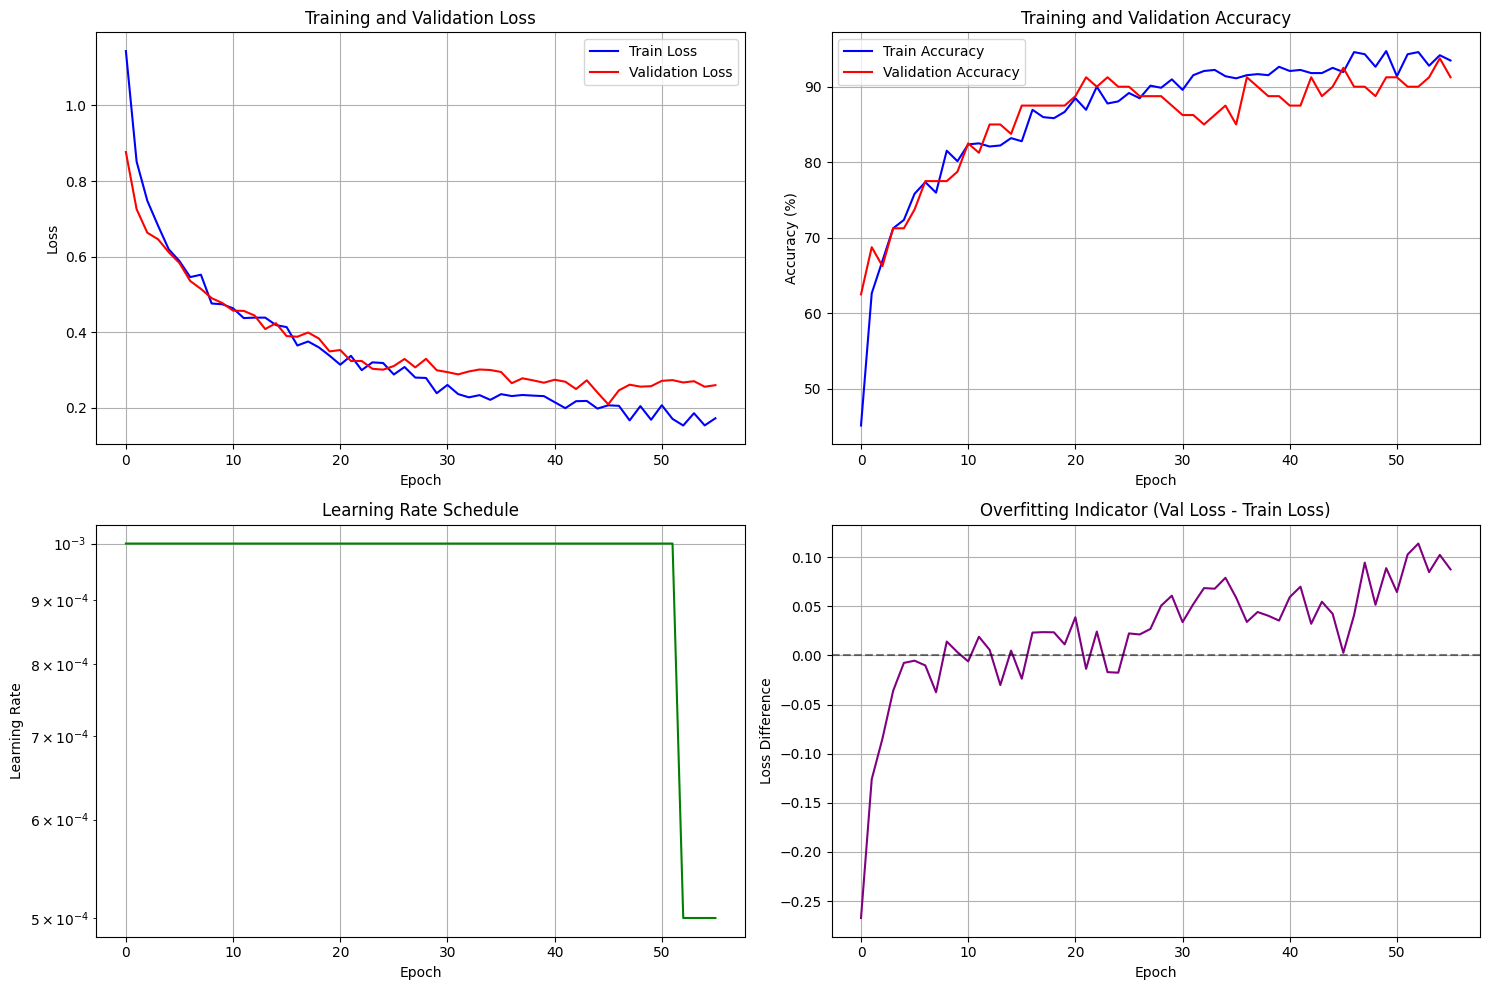

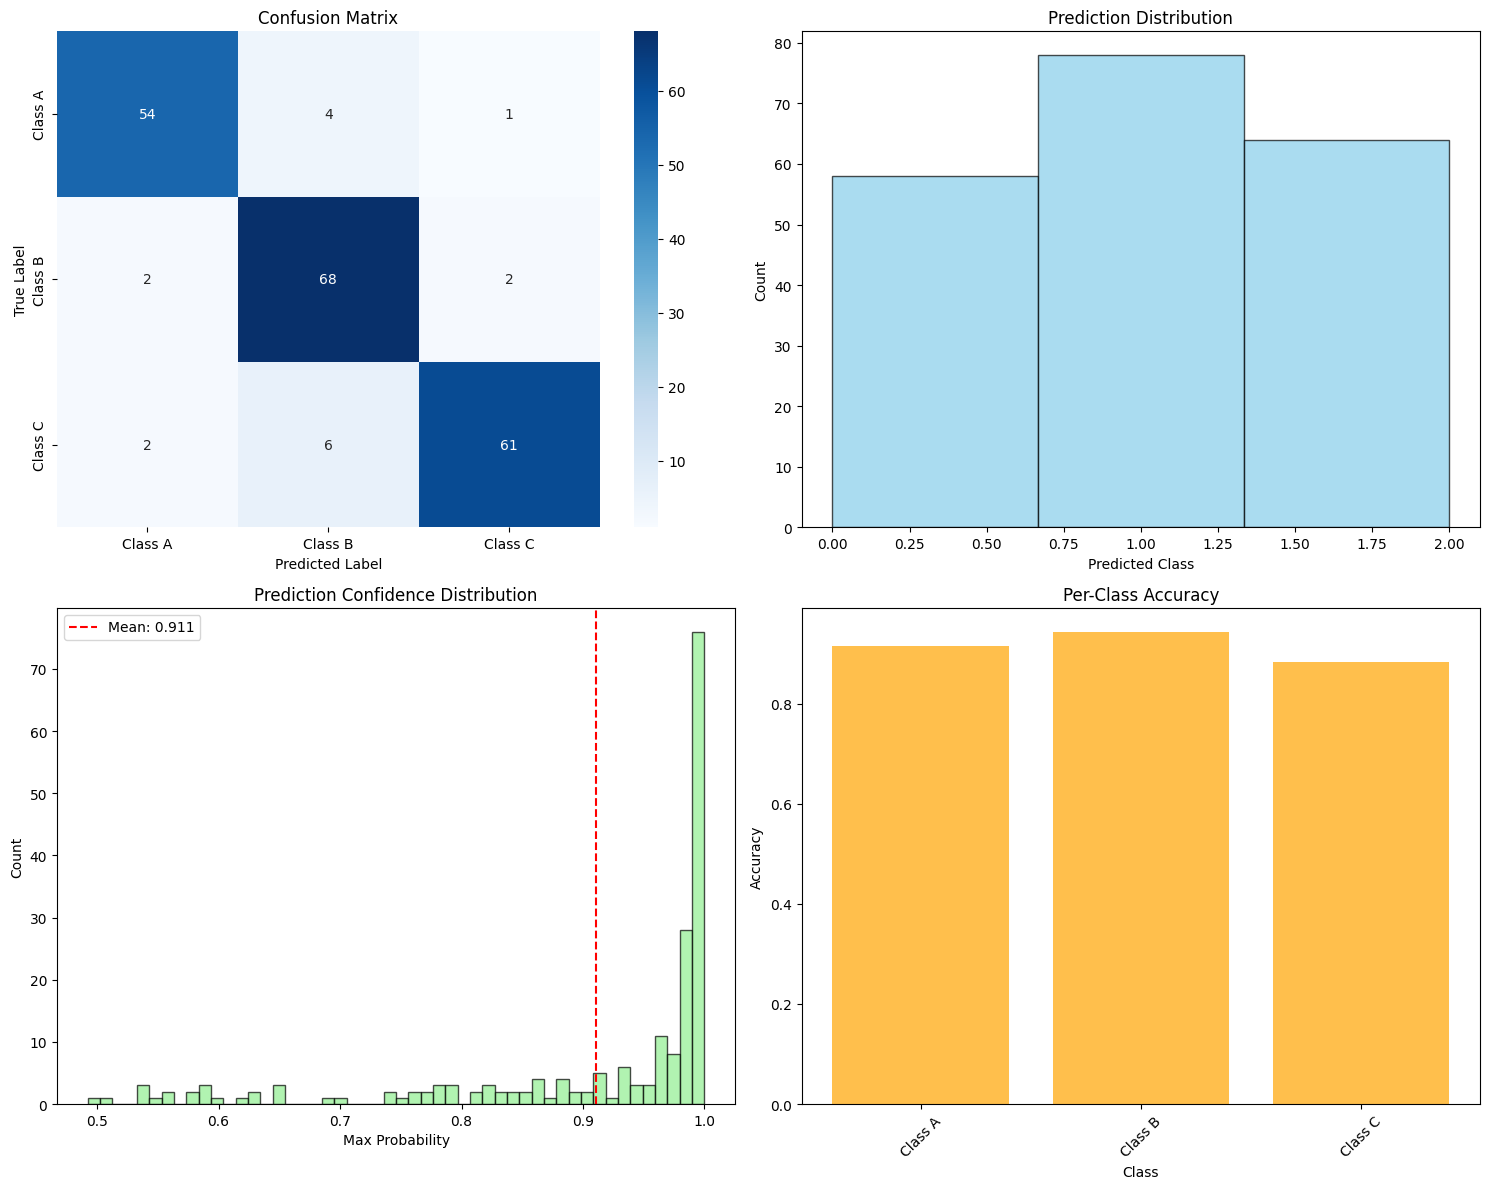


6. Generating summary report...
MODEL SUMMARY REPORT

1. MODEL ARCHITECTURE:
------------------------------
Total parameters: 11,523
Trainable parameters: 11,523
Model size: 0.04 MB (float32)

2. TRAINING SUMMARY:
------------------------------
Total epochs trained: 56
Final training loss: 0.1723
Final validation loss: 0.2598
Best validation loss: 0.2092
Final training accuracy: 93.47%
Final validation accuracy: 91.25%
Best validation accuracy: 93.75%

3. PERFORMANCE METRICS:
------------------------------
Test Accuracy: 0.9150
Test Precision: 0.9173
Test Recall: 0.9150
Test F1-Score: 0.9152

4. OVERFITTING ANALYSIS:
------------------------------
Final loss difference (val - train): 0.0875
✅ Model appears well-fitted

5. RECOMMENDATIONS:
------------------------------
• Model performance looks good
• Consider ensemble methods for further improvement
Model and results successfully saved to: classification_results

=== REGRESSION EXAMPLE ===
Starting complete training workflow...
Task 

Epoch 1/100 [Train]:   0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 453])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100 [Train]:  74%|███████▍  | 17/23 [00:00<00:00, 166.57it/s, Loss=17215.0425]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 453])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 168.89it/s, Loss=17029.7318]


Epoch 1: Train Loss: 17029.7318, Val Loss: 14693.8994


Epoch 2/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 153.63it/s, Loss=17152.4260]


Epoch 2: Train Loss: 17152.4260, Val Loss: 14509.7240


Epoch 3/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 189.99it/s, Loss=16627.8963]


Epoch 3: Train Loss: 16627.8963, Val Loss: 14190.6481


Epoch 4/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 170.12it/s, Loss=16492.4001]


Epoch 4: Train Loss: 16492.4001, Val Loss: 13892.7747


Epoch 5/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 180.54it/s, Loss=16276.9965]


Epoch 5: Train Loss: 16276.9965, Val Loss: 13532.0719


Epoch 6/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 164.44it/s, Loss=15871.6377]


Epoch 6: Train Loss: 15871.6377, Val Loss: 13247.7917


Epoch 7/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 160.91it/s, Loss=15358.8749]


Epoch 7: Train Loss: 15358.8749, Val Loss: 12805.4984


Epoch 8/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 146.77it/s, Loss=14546.7227]


Epoch 8: Train Loss: 14546.7227, Val Loss: 12266.5228


Epoch 9/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 160.60it/s, Loss=14227.6405]


Epoch 9: Train Loss: 14227.6405, Val Loss: 11976.1532


Epoch 10/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 180.90it/s, Loss=13660.9337]


Epoch 10: Train Loss: 13660.9337, Val Loss: 11547.6715


Epoch 11/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 182.64it/s, Loss=13360.5826]


Epoch 11: Train Loss: 13360.5826, Val Loss: 11129.6147


Epoch 12/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 168.85it/s, Loss=12738.0191]


Epoch 12: Train Loss: 12738.0191, Val Loss: 10586.2638


Epoch 13/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 150.98it/s, Loss=12351.0824]


Epoch 13: Train Loss: 12351.0824, Val Loss: 10293.4645


Epoch 14/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 140.05it/s, Loss=11784.3045]


Epoch 14: Train Loss: 11784.3045, Val Loss: 9815.8332


Epoch 15/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 185.79it/s, Loss=11379.6689]


Epoch 15: Train Loss: 11379.6689, Val Loss: 9267.6812


Epoch 16/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 166.51it/s, Loss=10782.2323]


Epoch 16: Train Loss: 10782.2323, Val Loss: 8718.5698


Epoch 17/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 182.08it/s, Loss=10312.6005]


Epoch 17: Train Loss: 10312.6005, Val Loss: 8333.7375


Epoch 18/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 170.61it/s, Loss=9612.0371]


Epoch 18: Train Loss: 9612.0371, Val Loss: 7962.4167


Epoch 19/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 179.42it/s, Loss=9194.8405]


Epoch 19: Train Loss: 9194.8405, Val Loss: 7509.5742


Epoch 20/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 152.69it/s, Loss=8764.2882]


Epoch 20: Train Loss: 8764.2882, Val Loss: 7155.6436


Epoch 21/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 142.15it/s, Loss=8293.3656]


Epoch 21: Train Loss: 8293.3656, Val Loss: 6886.0765


Epoch 22/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 167.89it/s, Loss=7661.7447]


Epoch 22: Train Loss: 7661.7447, Val Loss: 6386.1725


Epoch 23/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 165.53it/s, Loss=7356.2486]


Epoch 23: Train Loss: 7356.2486, Val Loss: 5530.8542


Epoch 24/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 173.19it/s, Loss=6721.6918]


Epoch 24: Train Loss: 6721.6918, Val Loss: 5397.1362


Epoch 25/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 171.99it/s, Loss=6354.4748]


Epoch 25: Train Loss: 6354.4748, Val Loss: 4942.8123


Epoch 26/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 177.91it/s, Loss=5870.3259]


Epoch 26: Train Loss: 5870.3259, Val Loss: 4444.4508


Epoch 27/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 173.71it/s, Loss=5361.9736]


Epoch 27: Train Loss: 5361.9736, Val Loss: 3758.6987


Epoch 28/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 151.80it/s, Loss=5134.6503]


Epoch 28: Train Loss: 5134.6503, Val Loss: 3803.9476


Epoch 29/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 148.64it/s, Loss=4756.2547]


Epoch 29: Train Loss: 4756.2547, Val Loss: 3334.9682


Epoch 30/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 174.36it/s, Loss=4509.2203]


Epoch 30: Train Loss: 4509.2203, Val Loss: 2926.6817


Epoch 31/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 195.79it/s, Loss=3956.2511]


Epoch 31: Train Loss: 3956.2511, Val Loss: 2884.5356


Epoch 32/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 193.46it/s, Loss=3806.7483]


Epoch 32: Train Loss: 3806.7483, Val Loss: 2688.4000


Epoch 33/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 175.49it/s, Loss=3408.2569]


Epoch 33: Train Loss: 3408.2569, Val Loss: 2147.9489


Epoch 34/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 158.13it/s, Loss=3351.7384]


Epoch 34: Train Loss: 3351.7384, Val Loss: 2216.3984


Epoch 35/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 151.07it/s, Loss=3021.0582]


Epoch 35: Train Loss: 3021.0582, Val Loss: 1952.2492


Epoch 36/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 160.27it/s, Loss=2757.1030]


Epoch 36: Train Loss: 2757.1030, Val Loss: 1377.7719


Epoch 37/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 186.96it/s, Loss=2478.6115]


Epoch 37: Train Loss: 2478.6115, Val Loss: 1507.4980


Epoch 38/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 189.30it/s, Loss=2402.0136]


Epoch 38: Train Loss: 2402.0136, Val Loss: 1426.3883


Epoch 39/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 186.53it/s, Loss=2292.3453]


Epoch 39: Train Loss: 2292.3453, Val Loss: 1491.0662


Epoch 40/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 181.96it/s, Loss=1912.2637]


Epoch 40: Train Loss: 1912.2637, Val Loss: 1193.1025


Epoch 41/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 154.63it/s, Loss=2008.3765]


Epoch 41: Train Loss: 2008.3765, Val Loss: 1044.3536


Epoch 42/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 171.24it/s, Loss=1813.2330]


Epoch 42: Train Loss: 1813.2330, Val Loss: 915.8519


Epoch 43/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 168.51it/s, Loss=1875.7618]


Epoch 43: Train Loss: 1875.7618, Val Loss: 749.2008


Epoch 44/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 168.08it/s, Loss=1664.8104]


Epoch 44: Train Loss: 1664.8104, Val Loss: 819.4124


Epoch 45/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 178.12it/s, Loss=1563.9079]


Epoch 45: Train Loss: 1563.9079, Val Loss: 474.4136


Epoch 46/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 157.11it/s, Loss=1341.1076]


Epoch 46: Train Loss: 1341.1076, Val Loss: 470.0930


Epoch 47/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 145.42it/s, Loss=1382.3053]


Epoch 47: Train Loss: 1382.3053, Val Loss: 376.3817


Epoch 48/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 136.97it/s, Loss=1298.8927]


Epoch 48: Train Loss: 1298.8927, Val Loss: 476.6165


Epoch 49/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 148.55it/s, Loss=1221.0637]


Epoch 49: Train Loss: 1221.0637, Val Loss: 457.7795


Epoch 50/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 148.37it/s, Loss=1486.3099]


Epoch 50: Train Loss: 1486.3099, Val Loss: 266.6289


Epoch 51/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 157.53it/s, Loss=1786.4007]


Epoch 51: Train Loss: 1786.4007, Val Loss: 279.9164


Epoch 52/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 179.12it/s, Loss=927.3808]


Epoch 52: Train Loss: 927.3808, Val Loss: 265.8244


Epoch 53/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 199.52it/s, Loss=1077.1621]


Epoch 53: Train Loss: 1077.1621, Val Loss: 146.6871


Epoch 54/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 149.29it/s, Loss=1445.5635]


Epoch 54: Train Loss: 1445.5635, Val Loss: 298.4547


Epoch 55/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 174.61it/s, Loss=1133.8838]


Epoch 55: Train Loss: 1133.8838, Val Loss: 174.2196


Epoch 56/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 192.31it/s, Loss=1125.7127]


Epoch 56: Train Loss: 1125.7127, Val Loss: 105.2418


Epoch 57/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 187.04it/s, Loss=1264.4878]


Epoch 57: Train Loss: 1264.4878, Val Loss: 153.5801


Epoch 58/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 170.60it/s, Loss=962.5180]


Epoch 58: Train Loss: 962.5180, Val Loss: 121.1653


Epoch 59/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 151.88it/s, Loss=982.4616]


Epoch 59: Train Loss: 982.4616, Val Loss: 91.1245


Epoch 60/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 180.16it/s, Loss=1509.3695]


Epoch 60: Train Loss: 1509.3695, Val Loss: 135.7520


Epoch 61/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 160.53it/s, Loss=1337.4114]


Epoch 61: Train Loss: 1337.4114, Val Loss: 177.6370


Epoch 62/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 139.01it/s, Loss=1175.1082]


Epoch 62: Train Loss: 1175.1082, Val Loss: 274.1810


Epoch 63/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 166.19it/s, Loss=1044.5411]


Epoch 63: Train Loss: 1044.5411, Val Loss: 27.8868


Epoch 64/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 187.78it/s, Loss=967.6575]


Epoch 64: Train Loss: 967.6575, Val Loss: 109.8059


Epoch 65/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 194.18it/s, Loss=886.5500]


Epoch 65: Train Loss: 886.5500, Val Loss: 61.2145


Epoch 66/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 163.22it/s, Loss=1359.8246]


Epoch 66: Train Loss: 1359.8246, Val Loss: 148.8062


Epoch 67/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 175.82it/s, Loss=1172.7931]


Epoch 67: Train Loss: 1172.7931, Val Loss: 86.0550


Epoch 68/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 187.61it/s, Loss=923.5628]


Epoch 68: Train Loss: 923.5628, Val Loss: 114.9430


Epoch 69/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 159.93it/s, Loss=934.0446]


Epoch 69: Train Loss: 934.0446, Val Loss: 145.3321


Epoch 70/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 192.07it/s, Loss=1088.3538]


Epoch 70: Train Loss: 1088.3538, Val Loss: 165.7951


Epoch 71/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 144.30it/s, Loss=1092.3773]


Epoch 71: Train Loss: 1092.3773, Val Loss: 40.4253


Epoch 72/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 166.12it/s, Loss=1382.1003]


Epoch 72: Train Loss: 1382.1003, Val Loss: 44.4667


Epoch 73/100 [Train]: 100%|██████████| 23/23 [00:00<00:00, 151.24it/s, Loss=967.0493]


Epoch 73: Train Loss: 967.0493, Val Loss: 66.8825
Early stopping triggered after epoch 73

4. Evaluating model...
Evaluating on test set...
Evaluating model on test set with 7 batches...
Making predictions on 7 batches...
Batch 0: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 453])
Batch 1: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 453])
Batch 2: data shape torch.Size([32, 10]), target shape torch.Size([32]), output shape torch.Size([32, 453])
Final predictions shape: (90600,)
Final true_labels shape: (200,)
Truncated to size: 200
Evaluation - Predictions shape: (200,)
Evaluation - True labels shape: (200,)
Regression metrics calculated successfully:
MSE: 27550.2852
RMSE: 165.9828
MAE: 133.6551
R²: -0.4511
Evaluating on validation set...
Evaluating model on test set with 3 batches...
Making predictions on 3 batches...
Batch 0: data shape torch.Size([32, 10]), target shape torch.Size([32]),

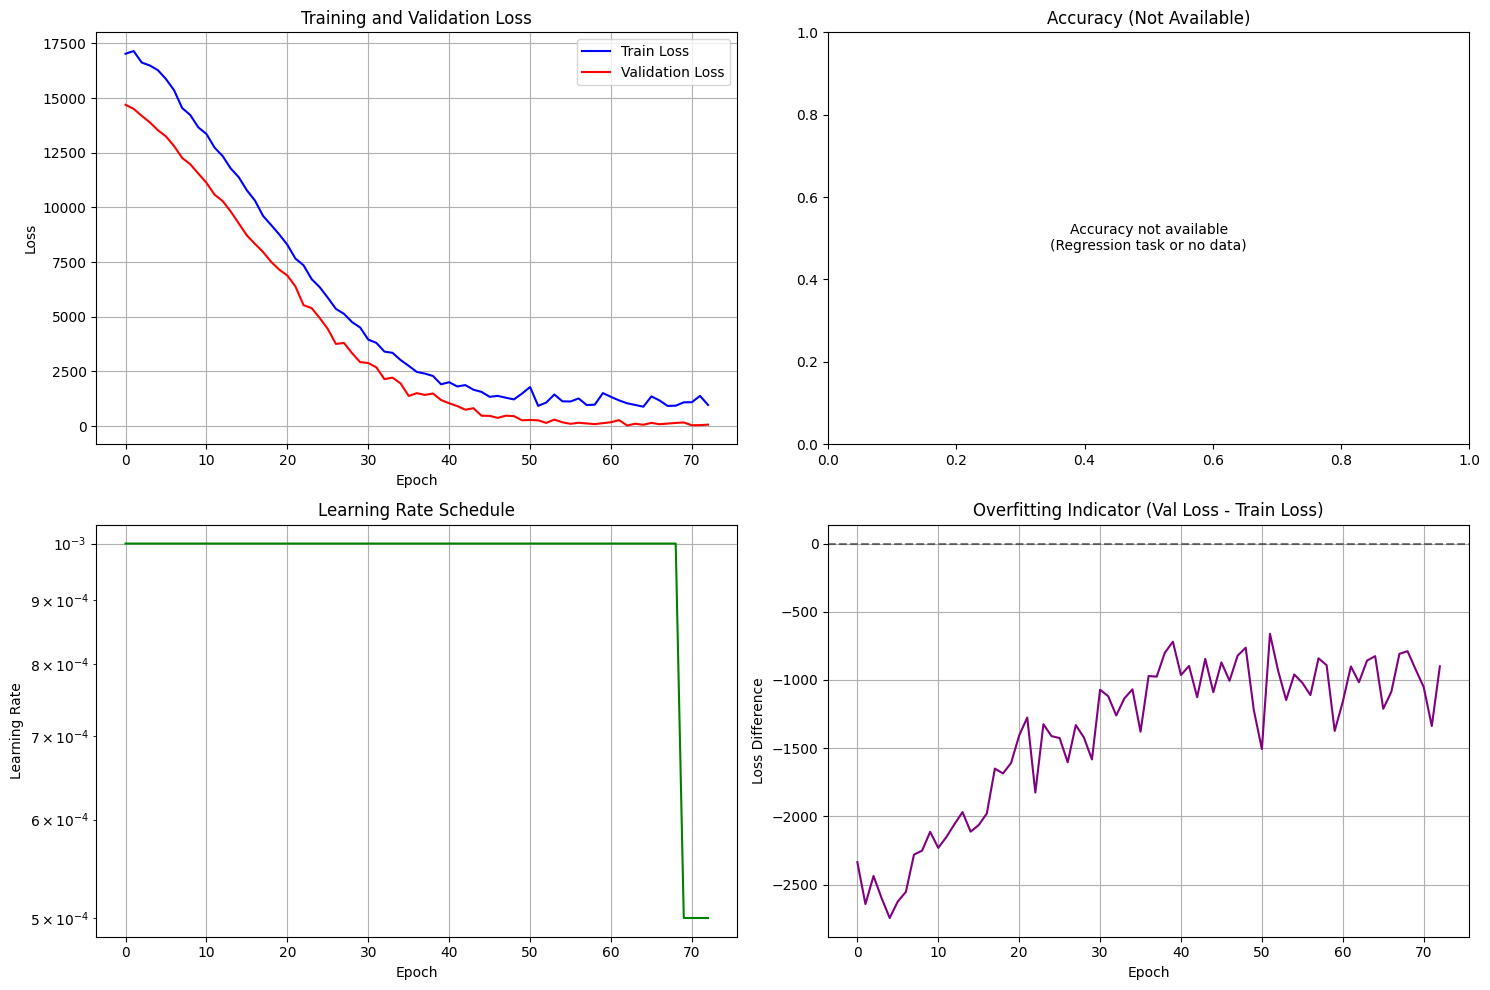

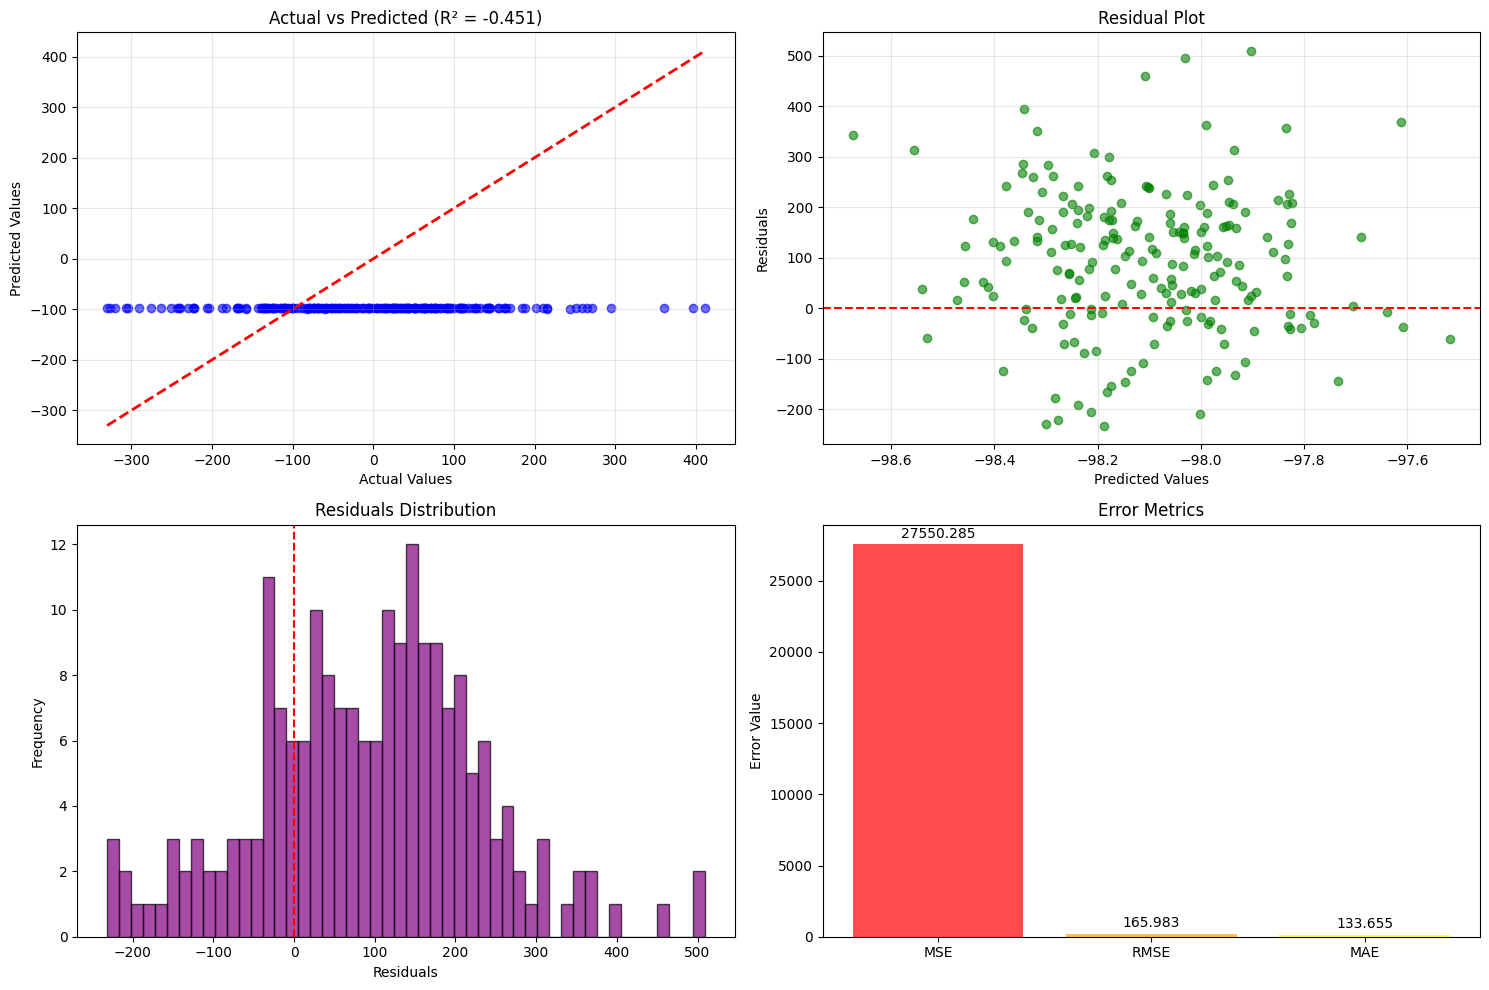


6. Generating summary report...
MODEL SUMMARY REPORT

1. MODEL ARCHITECTURE:
------------------------------
Total parameters: 39,493
Trainable parameters: 39,493
Model size: 0.15 MB (float32)

2. TRAINING SUMMARY:
------------------------------
Total epochs trained: 73
Final training loss: 967.0493
Final validation loss: 66.8825
Best validation loss: 27.8868
Accuracy data available but empty or incomplete.

3. PERFORMANCE METRICS:
------------------------------
Test MSE: 27550.2852
Test RMSE: 165.9828
Test MAE: 133.6551
Test R² Score: -0.4511

4. OVERFITTING ANALYSIS:
------------------------------
Final loss difference (val - train): -900.1668
⚠️  WARNING: Model may be underfitting

5. RECOMMENDATIONS:
------------------------------
• Consider increasing model complexity
• Reduce regularization
• Train for more epochs
• Check for data quality issues
Model and results successfully saved to: regression_results


In [20]:
# 10. UTILITY FUNCTIONS

def load_model(model_path, config_path):
    """
    Load a saved model

    Args:
        model_path: Path to model weights
        config_path: Path to configuration file

    Returns:
        Loaded model
    """
    with open(config_path, 'r') as f:
        config = json.load(f)

    model = create_model(
        input_size=config['input_size'],
        num_classes=config['num_classes'],
        hidden_sizes=config['model_config']['hidden_sizes'],
        dropout_rate=config['model_config']['dropout_rate'],
        activation=config['model_config']['activation'],
        batch_norm=config['model_config']['batch_norm'],
        task_type=config['task_type']
    )

    model.load_state_dict(torch.load(model_path))
    return model

def predict_new_data(model, X_new, device='auto', task_type='classification',
                    scaler=None):
    """
    Make predictions on new data

    Args:
        model: Trained model
        X_new: New input data
        device: Device to use
        task_type: 'classification' or 'regression'
        scaler: Scaler used during training (if any)

    Returns:
        Predictions
    """
    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()

    # Apply scaling if provided
    if scaler is not None:
        X_new = scaler.transform(X_new)

    # Convert to tensor
    X_tensor = torch.FloatTensor(X_new).to(device)

    with torch.no_grad():
        output = model(X_tensor)

        if task_type == 'classification':
            probabilities = torch.softmax(output, dim=1)
            predictions = torch.argmax(output, dim=1)
            return predictions.cpu().numpy(), probabilities.cpu().numpy()
        else:
            return output.cpu().numpy().flatten()

# Run example if this script is executed directly
if __name__ == "__main__":
    example_usage()